# Titulo

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Imports
import pickle as pk
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from IPython.display import clear_output
import sklearn.neural_network as sknn

# Leitura e exploração dos dados

There are 39.92506244796004% of nominal cases


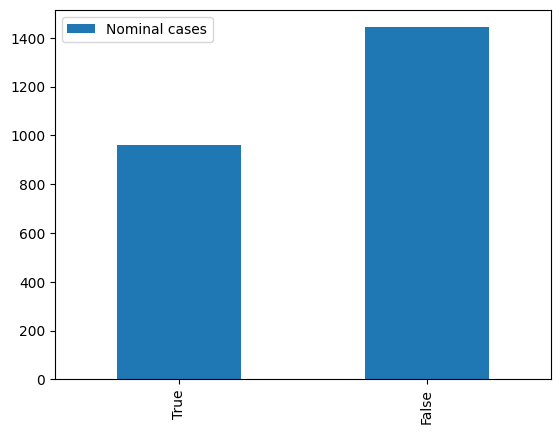

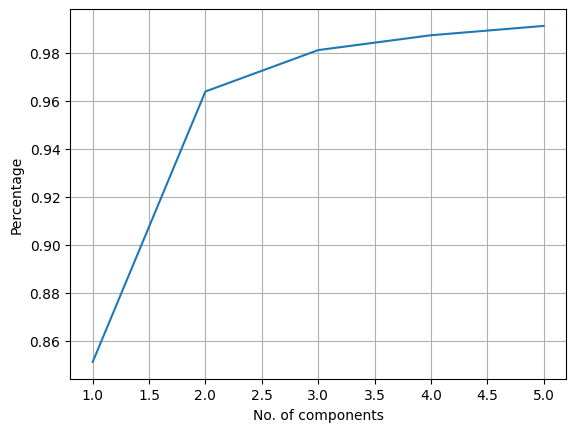

In [ ]:
### Extraindo os dados
#path = "/content/drive/MyDrive/Colab Notebooks/TCC/"
path = "output/"
with open(path+"Tsdata.pickle", "rb") as fname:
    ([Xts]) = pk.load(fname)

with open(path+"alldata_info.pickle", "rb") as fname:
    (df2save) = pk.load(fname)

df2save['target'] = (df2save['case'] == 'A') | (df2save['case'] == 'B') | (df2save['case'] == 'C') | (df2save['case'] == 'R')
df2save['target'].value_counts().sort_values().plot(kind='bar')
plt.legend({'Nominal cases'})

print('There are ' + str(df2save['target'].sum()/len(df2save['target'])*100) + '% of nominal cases')

y = df2save['target']

### PCA + Graficos
pctExplVar = 0.99
pca = PCA(n_components=pctExplVar)
Xtsred = pca.fit_transform(Xts)

plt.figure()
plt.plot(np.arange(len(np.cumsum(pca.explained_variance_ratio_)))+1,np.cumsum(pca.explained_variance_ratio_))
plt.grid()
plt.ylabel('Percentage')
plt.xlabel('No. of components')
plt.show()

In [ ]:
Xts.shape, Xtsred.shape

((2402, 48), (2402, 5))

In [ ]:
Xtsred[0:5,:]

array([[-5.53551908,  1.17782852,  0.2242756 , -0.15904104, -0.24356281],
       [-5.68152683,  1.0116827 ,  0.15158924, -0.10148506, -0.08661173],
       [-5.64041655,  0.8850916 ,  0.1326918 ,  0.03178893,  0.11990451],
       [-5.74539635,  1.20623889,  0.24005609, -0.17148133, -0.23251438],
       [-5.68920261,  1.07014931,  0.13065075, -0.13051693, -0.0616693 ]])

Plotando os reusltados do PCA nos gráficos abaixo podemos observar claramente que temos alguns outliers nos dados.

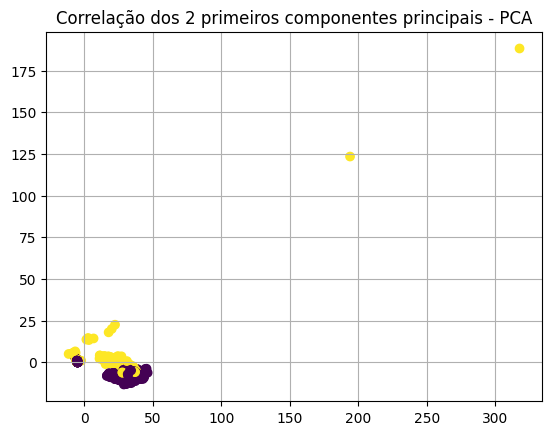

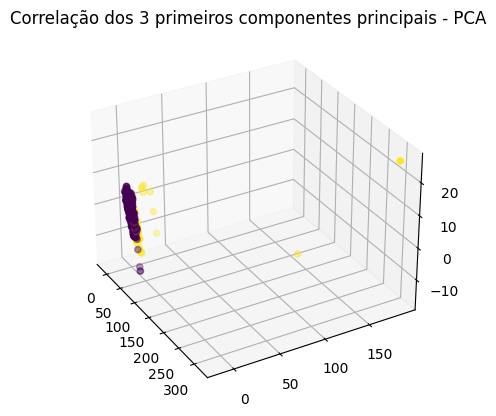

In [ ]:
# Gráficos 2/3D - Resultado do PCA
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(Xtsred[:,0],Xtsred[:,1],c = y)
ax.grid()
ax.set_title("Correlação dos 2 primeiros componentes principais - PCA")
plt.show()


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(Xtsred[:,0],Xtsred[:,1],Xtsred[:,2],c = y)
ax.set_title("Correlação dos 3 primeiros componentes principais - PCA")
ax.grid()

#Default = 30 -60 0
ax.view_init(30, -30, 0)
plt.show()


A função abaixo foi utlizada para filtrar outliers nos dados.

In [ ]:
# Função para filtrar outliers
def reject_outliers(data, m = 4.):
    data = data[:,0]
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev.all() else np.zeros(len(d))
    return s<m

map = reject_outliers(Xtsred)

Nos gráficos abaixo, podemos observar que os outliers possuem uma fração maior de casos com presença de dano quando comparado aos não outliers, mas ainda possuem uma quantidade significativa de casos nominais

383 2019 2402


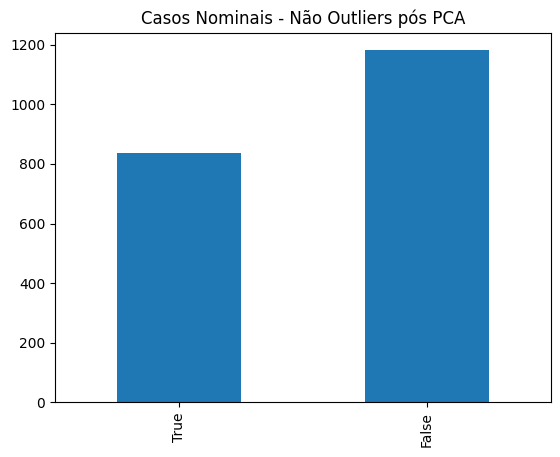

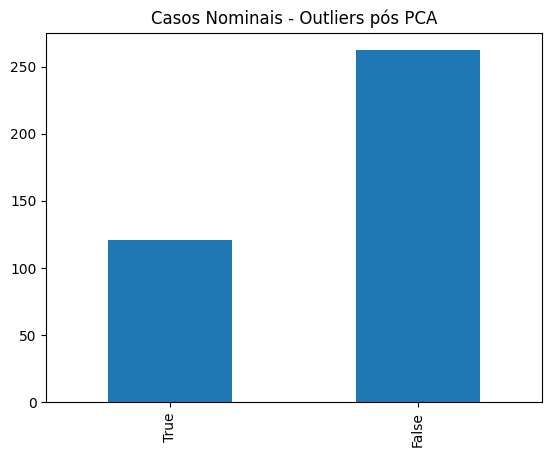

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
# Graifco - Não Dano x Dano nos outliers e não outliers
print(np.sum(np.invert(map)),np.sum(map),len(map))
df2save['target'].loc[map].value_counts().sort_values().plot(kind='bar')

plt.title("Casos Nominais - Não Outliers pós PCA")
plt.show()
plt.figure()

df2save['target'].loc[np.invert(map)].value_counts().sort_values().plot(kind='bar')
plt.title("Casos Nominais - Outliers pós PCA")
plt.show()
plt.figure()

Realizamos novamente os gráficos para autocorrelação ddos componentes principais, dessa vez filtrando os outliers. A função de filtragem parece ter sido adequada.

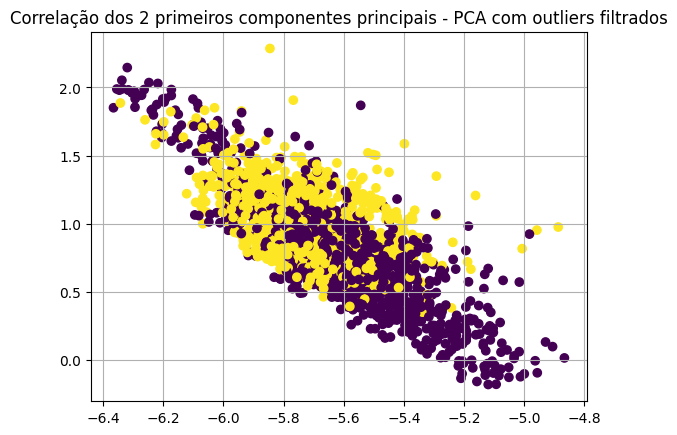

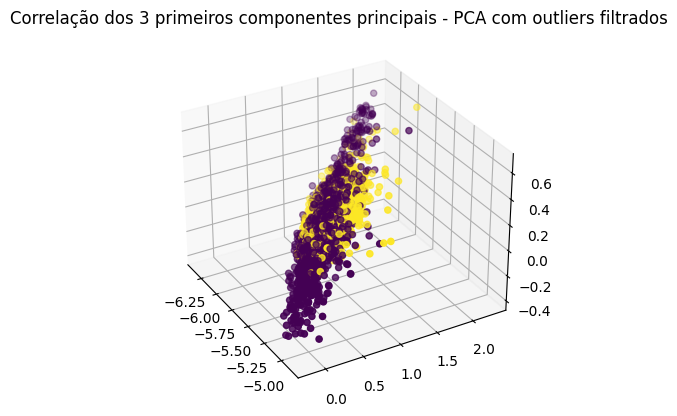

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(Xtsred[map,0],Xtsred[map,1],c = y[map])
ax.set_title("Correlação dos 2 primeiros componentes principais - PCA com outliers filtrados")
ax.grid()
plt.show()


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(Xtsred[map,0],Xtsred[map,1],Xtsred[map,2],c = y[map])
ax.set_title("Correlação dos 3 primeiros componentes principais - PCA com outliers filtrados")
ax.grid()

#Default = 30 -60 0
ax.view_init(30, -30, 0)
plt.show()


Hipotese alternativa: Realizar a filtragem de outliers antes do PCA.

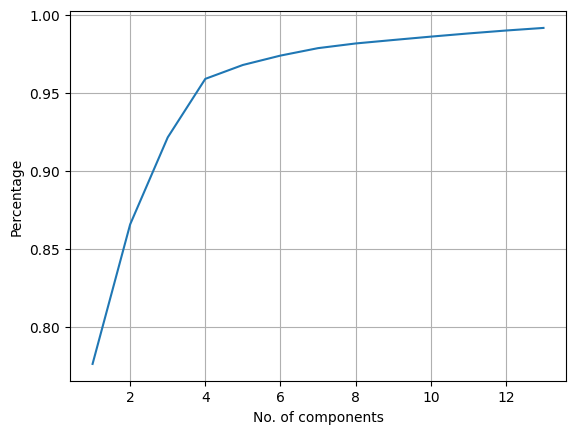

2402
2012 None


In [ ]:
# Filtragem + PCA
pctExplVar = 0.99
pca2 = PCA(n_components=pctExplVar)

#Realizamos o fit no conjunto filtrado, mas mantemos o conjunto inteiro após a transformada
map_xts = reject_outliers(Xts)
pca2.fit(Xts[map_xts])
Xtsred_filtered = pca2.transform(Xts)

plt.figure()
plt.plot(np.arange(len(np.cumsum(pca2.explained_variance_ratio_)))+1,np.cumsum(pca2.explained_variance_ratio_))
plt.grid()
plt.ylabel('Percentage')
plt.xlabel('No. of components')
plt.show()
print(sum(map_xts),print(len(Xts)))

Observamos que ao remover os outliers antes de realizar o PCA, o numero de componentes necessários para atingir 99% de variancia explicada sobe drasticamente, de 5 para 13.

Abaixo, plotamos o grafico de autocorrelação para os componentes principais do novo PCA obtido. Observe que os outliers foram mantidos apos a transformada, tendo sido apenas desconsiderados para montar a matriz do PCA.

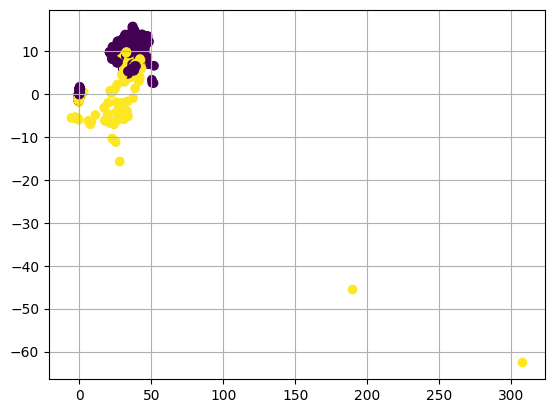

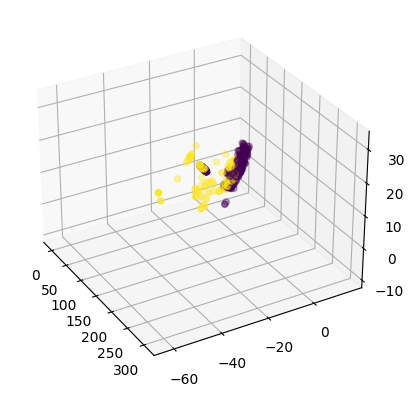

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(Xtsred_filtered[:,0],Xtsred_filtered[:,1],c = y)
ax.grid()
plt.show()


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(Xtsred_filtered[:,0],Xtsred_filtered[:,1],Xtsred_filtered[:,2],c = y)
ax.grid()

#Default = 30 -60 0
ax.view_init(30, -30, 0)
plt.show()

# Testing without PCA

In [ ]:
index_modelos = ["Decision tree","Ridge classifier","SVC"]

In [47]:
X = StandardScaler().fit_transform(X=Xts)

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.4,random_state=0)

tree = DecisionTreeClassifier()
tree.fit(X_train,y_train)
ytree = tree.predict(X_test)

ridg = RidgeClassifier()
ridg.fit(X_train,y_train)
yridg = ridg.predict(X_test)

svc = SVC()
svc.fit(X_train,y_train)
ysvc = svc.predict(X_test)

print("Confusion matrix results:")
print(confusion_matrix(y_test, ytree))
print(confusion_matrix(y_test, yridg))
print(confusion_matrix(y_test, ysvc))
print()

ba_tree = metrics.balanced_accuracy_score(y_test, ytree)
ba_ridg = metrics.balanced_accuracy_score(y_test, yridg)
ba_svc = metrics.balanced_accuracy_score(y_test, ysvc)
print("Balanced accuracy")
print(ba_tree)
print(ba_ridg)
print(ba_svc)
print()

f1_tree = metrics.f1_score(y_test, ytree)
f1_ridg = metrics.f1_score(y_test, yridg)
f1_svc = metrics.f1_score(y_test, ysvc)
print("F1 score")
print(f1_tree)
print(f1_ridg)
print(f1_svc)
print()

re_tree = metrics.recall_score(y_test, ytree)
re_ridg = metrics.recall_score(y_test, yridg)
re_svc = metrics.recall_score(y_test, ysvc)
print("Recall score")
print(re_tree)
print(re_ridg)
print(re_svc)

test_results = {"BA":[ba_tree,ba_ridg,ba_svc],"F1":[f1_tree,f1_ridg,f1_svc],"Recall":[re_tree,re_ridg,re_svc]}

df_no_pca = pd.DataFrame(test_results, index = index_modelos)
print(df_no_pca)

Confusion matrix results:
[[540  23]
 [ 25 373]]
[[553  10]
 [ 61 337]]
[[550  13]
 [ 76 322]]

Balanced accuracy
0.9481666770798933
0.9144858394994511
0.8929773199925024

F1 score
0.9395465994962218
0.9046979865771811
0.878581173260573

Recall score
0.9371859296482412
0.8467336683417085
0.8090452261306532
                        BA        F1    Recall
Decision tree     0.948167  0.939547  0.937186
Ridge classifier  0.914486  0.904698  0.846734
SVC               0.892977  0.878581  0.809045


# Testing with basic PCA

In [48]:
X = StandardScaler().fit_transform(X=Xtsred)

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.4,random_state=0)

tree = DecisionTreeClassifier()
tree.fit(X_train,y_train)
ytree = tree.predict(X_test)

ridg = RidgeClassifier()
ridg.fit(X_train,y_train)
yridg = ridg.predict(X_test)

svc = SVC()
svc.fit(X_train,y_train)
ysvc = svc.predict(X_test)

ba_tree = metrics.balanced_accuracy_score(y_test, ytree)
ba_ridg = metrics.balanced_accuracy_score(y_test, yridg)
ba_svc = metrics.balanced_accuracy_score(y_test, ysvc)
print("Balanced accuracy")
print(ba_tree)
print(ba_ridg)
print(ba_svc)
print()

f1_tree = metrics.f1_score(y_test, ytree)
f1_ridg = metrics.f1_score(y_test, yridg)
f1_svc = metrics.f1_score(y_test, ysvc)
print("F1 score")
print(f1_tree)
print(f1_ridg)
print(f1_svc)
print()

re_tree = metrics.recall_score(y_test, ytree)
re_ridg = metrics.recall_score(y_test, yridg)
re_svc = metrics.recall_score(y_test, ysvc)
print("Recall score")
print(re_tree)
print(re_ridg)
print(re_svc)

test_results = {"BA":[ba_tree,ba_ridg,ba_svc],"F1":[f1_tree,f1_ridg,f1_svc],"Recall":[re_tree,re_ridg,re_svc]}

df_pca1 = pd.DataFrame(test_results, index = index_modelos)
print(df_pca1)

Balanced accuracy
0.7760962896186081
0.5388353847389702
0.8009853887555004

F1 score
0.7377666248431618
0.21052631578947367
0.7621621621621621

Recall score
0.7386934673366834
0.12562814070351758
0.7085427135678392
                        BA        F1    Recall
Decision tree     0.776096  0.737767  0.738693
Ridge classifier  0.538835  0.210526  0.125628
SVC               0.800985  0.762162  0.708543


# Testing filtering after PCA

In [51]:
X = StandardScaler().fit_transform(X=Xtsred[map,:])

X_train, X_test, y_train, y_test = train_test_split(X, y[map],test_size=0.4,random_state=0)

tree = DecisionTreeClassifier()
tree.fit(X_train,y_train)
ytree = tree.predict(X_test)

ridg = RidgeClassifier()
ridg.fit(X_train,y_train)
yridg = ridg.predict(X_test)

svc = SVC()
svc.fit(X_train,y_train)
ysvc = svc.predict(X_test)

ba_tree = metrics.balanced_accuracy_score(y_test, ytree)
ba_ridg = metrics.balanced_accuracy_score(y_test, yridg)
ba_svc = metrics.balanced_accuracy_score(y_test, ysvc)
print("Balanced accuracy")
print(ba_tree)
print(ba_ridg)
print(ba_svc)
print()

f1_tree = metrics.f1_score(y_test, ytree)
f1_ridg = metrics.f1_score(y_test, yridg)
f1_svc = metrics.f1_score(y_test, ysvc)
print("F1 score")
print(f1_tree)
print(f1_ridg)
print(f1_svc)
print()

re_tree = metrics.recall_score(y_test, ytree)
re_ridg = metrics.recall_score(y_test, yridg)
re_svc = metrics.recall_score(y_test, ysvc)
print("Recall score")
print(re_tree)
print(re_ridg)
print(re_svc)

test_results = {"BA":[ba_tree,ba_ridg,ba_svc],"F1":[f1_tree,f1_ridg,f1_svc],"Recall":[re_tree,re_ridg,re_svc]}

df_pca2 = pd.DataFrame(test_results, index = index_modelos)
print(df_pca2)

Balanced accuracy
0.7592442339503493
0.8092627884597241
0.8417992213395726

F1 score
0.725212464589235
0.7779433681073025
0.8164464023494861

Recall score
0.7551622418879056
0.7699115044247787
0.8200589970501475
                        BA        F1    Recall
Decision tree     0.759244  0.725212  0.755162
Ridge classifier  0.809263  0.777943  0.769912
SVC               0.841799  0.816446  0.820059


# Testing filtering before PCA

In [55]:
Xtsred_filtered

X = StandardScaler().fit_transform(X=Xtsred_filtered)

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.4,random_state=0)

tree = DecisionTreeClassifier()
tree.fit(X_train,y_train)
ytree = tree.predict(X_test)

ridg = RidgeClassifier()
ridg.fit(X_train,y_train)
yridg = ridg.predict(X_test)

svc = SVC()
svc.fit(X_train,y_train)
ysvc = svc.predict(X_test)

ba_tree = metrics.balanced_accuracy_score(y_test, ytree)
ba_ridg = metrics.balanced_accuracy_score(y_test, yridg)
ba_svc = metrics.balanced_accuracy_score(y_test, ysvc)
print("Balanced accuracy")
print(ba_tree)
print(ba_ridg)
print(ba_svc)
print()

f1_tree = metrics.f1_score(y_test, ytree)
f1_ridg = metrics.f1_score(y_test, yridg)
f1_svc = metrics.f1_score(y_test, ysvc)
print("F1 score")
print(f1_tree)
print(f1_ridg)
print(f1_svc)
print()

re_tree = metrics.recall_score(y_test, ytree)
re_ridg = metrics.recall_score(y_test, yridg)
re_svc = metrics.recall_score(y_test, ysvc)
print("Recall score")
print(re_tree)
print(re_ridg)
print(re_svc)

test_results = {"BA":[ba_tree,ba_ridg,ba_svc],"F1":[f1_tree,f1_ridg,f1_svc],"Recall":[re_tree,re_ridg,re_svc]}

df_pca3 = pd.DataFrame(test_results, index = index_modelos)
print(df_pca3)

Balanced accuracy
0.8532940010889261
0.8156501869917974
0.8749341735319582

F1 score
0.8281053952321203
0.778561354019746
0.8555858310626703

Recall score
0.8291457286432161
0.6934673366834171
0.7889447236180904
                        BA        F1    Recall
Decision tree     0.853294  0.828105  0.829146
Ridge classifier  0.815650  0.778561  0.693467
SVC               0.874934  0.855586  0.788945


Resultados obtidos antes da busca de parametros:

In [56]:
df_resultados = pd.concat([df_no_pca, df_pca1, df_pca2, df_pca3], keys=['No PCA', 'PCA', 'PCA -> Filter', 'Filter -> PCA'])
df_resultados

BA        F1    Recall
No PCA        Decision tree     0.948167  0.939547  0.937186
              Ridge classifier  0.914486  0.904698  0.846734
              SVC               0.892977  0.878581  0.809045
PCA           Decision tree     0.776096  0.737767  0.738693
              Ridge classifier  0.538835  0.210526  0.125628
              SVC               0.800985  0.762162  0.708543
PCA -> Filter Decision tree     0.759244  0.725212  0.755162
              Ridge classifier  0.809263  0.777943  0.769912
              SVC               0.841799  0.816446  0.820059
Filter -> PCA Decision tree     0.853294  0.828105  0.829146
              Ridge classifier  0.815650  0.778561  0.693467
              SVC               0.874934  0.855586  0.788945

Observamos que os modelos treinados no conjunto original dos dados obtiveram consistentemente uma melhor performance quando comparados aos modelos treinados com o uso de PCA. Além disso, observamos que dentre os 3 testes com PCA realizados, aplicar a filtragem de outliers antes de utilizar o metodo demonstrou resultados melhores.

Para o PCA simples houve um resultado particurlarmente ruim para o ridge classifier, com um recall de apenas 0.1256. Utilizando o filtro pos-PCA aumentou significativamente a performance desse modelo.

# Parameter search:

In [ ]:
param_dist = {
    "criterion":["gini","entropy","log_loss"],
    "max_depth":[None,10,20,30],
    "max_leaf_nodes":[None,30,40,50,60,70],
    "max_features" :[None,2,3],
    "splitter":["best"]
}

tree = DecisionTreeClassifier()
rkf = RepeatedKFold(n_splits=5, n_repeats=10)
#tree_random_search = RandomizedSearchCV(tree, param_dist, random_state=0, n_iter = 100, verbose = 4, cv = 5)
tree_random_search = GridSearchCV(tree, param_dist, verbose = 4, cv = rkf)
tree_search_result = tree_random_search.fit(X_train, y_train)

clear_output()
print(tree_search_result.best_params_)

tree = DecisionTreeClassifier(**tree_search_result.best_params_)
tree.fit(X_train,y_train)
yytree = tree.predict(X_test)

print("tree results")
print("Optimized")
print(metrics.balanced_accuracy_score(y_test, yytree))
print(metrics.f1_score(y_test, yytree))
print(metrics.recall_score(y_test, yytree))

print("Unoptimezed")
print(metrics.balanced_accuracy_score(y_test, ytree))
print(metrics.f1_score(y_test, ytree))
print(metrics.recall_score(y_test, ytree))

{'criterion': 'gini', 'max_depth': 30, 'max_features': None, 'max_leaf_nodes': 30, 'splitter': 'best'}
tree results
Optimized
0.8787454144612941
0.858611825192802
0.8391959798994975
Unoptimezed
0.8586225978917679
0.8343868520859672
0.8291457286432161


In [ ]:
param_dist = {
    "alpha": sp_randFloat(0,2),
    "class_weight":["balanced",None],
    "solver":["svd","cholesky","lsqr","sparse_cg","sag","saga","lbfgs"]
}

ridg = RidgeClassifier()
rkf = RepeatedKFold(n_splits=5, n_repeats=5)
ridg_random_search = RandomizedSearchCV(ridg, param_dist, random_state=0, n_iter = 100, verbose = 4, cv = rkf)
ridg_search_result = ridg_random_search.fit(X_train, y_train)

clear_output()
print(ridg_search_result.best_params_)

ridg = RidgeClassifier(**ridg_search_result.best_params_)
ridg.fit(X_train,y_train)
yyridg = ridg.predict(X_test)

print("ridg results")
print("Optimized")
print(metrics.balanced_accuracy_score(y_test, yyridg))
print(metrics.f1_score(y_test, yyridg))
print(metrics.recall_score(y_test, yyridg))

print("Unoptimezed")
print(metrics.balanced_accuracy_score(y_test, yridg))
print(metrics.f1_score(y_test, yridg))
print(metrics.recall_score(y_test, yridg))

{'alpha': 0.36638272401423366, 'class_weight': 'balanced', 'solver': 'sparse_cg'}
ridg results
Optimized
0.839843087551434
0.8121827411167513
0.8040201005025126
Unoptimezed
0.8156501869917974
0.778561354019746
0.6934673366834171


In [ ]:
param_dist = {
    "kernel":['linear','poly', 'rbf', 'sigmoid'],
    "gamma":["auto","scale"],
    "coef0":sp_randFloat(-1,1),
    "degree":sp_randInt(2,6)
}

svc = SVC()
rkf = RepeatedKFold(n_splits=5, n_repeats=5)
svc_random_search = RandomizedSearchCV(svc, param_dist, random_state=0, n_iter = 100, verbose = 4, cv = rkf)
svc_search_result = svc_random_search.fit(X_train, y_train)

clear_output()
print(svc_search_result.best_params_)

svc = SVC(**svc_search_result.best_params_)
svc.fit(X_train,y_train)
yysvc = svc.predict(X_test)

print("SVC results")
print("Optimized")
print(metrics.balanced_accuracy_score(y_test, yysvc))
print(metrics.f1_score(y_test, yysvc))
print(metrics.recall_score(y_test, yysvc))

print("Unoptimezed")
print(metrics.balanced_accuracy_score(y_test, ysvc))
print(metrics.f1_score(y_test, ysvc))
print(metrics.recall_score(y_test, ysvc))

{'coef0': -0.07884238976280022, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
SVC results
Optimized
0.8769268188187831
0.8579161028416779
0.7964824120603015
Unoptimezed
0.8749341735319582
0.8555858310626703
0.7889447236180904
